In [1]:
# Credit Card Default Prediction Model with Business Integration and Fairness Safeguards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import shap

In [14]:
# === Load data ===
application_data = pd.read_csv("application_record.csv", encoding='cp1252')
credit_data = pd.read_csv("credit_record.csv", encoding='cp1252')


UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 178: character maps to <undefined>

In [9]:
# === Create default label ===
defaulters = credit_data.copy()
defaulters['STATUS_NUMERIC'] = pd.to_numeric(defaulters['STATUS'], errors='coerce')
defaulter_flag = defaulters.groupby('ID')['STATUS_NUMERIC'].max().apply(lambda x: 1 if x >= 2 else 0).reset_index()
defaulter_flag.columns = ['ID', 'DEFAULT']

In [11]:
# === Merge datasets ===
merged_data = pd.merge(application_data, defaulter_flag, on='ID', how='left')
merged_data['DEFAULT'] = merged_data['DEFAULT'].fillna(0).astype(int)

In [13]:
# === Preprocessing ===
data = merged_data.drop(columns=['ID', 'CODE_GENDER'])  # remove ID and gender
X = data.drop('DEFAULT', axis=1)
y = data['DEFAULT']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X[categorical_cols] = X[categorical_cols].fillna('Missing')
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

imputer = SimpleImputer(strategy='median')
X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [15]:
# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [17]:
# === Hyperparameter tuning with GridSearchCV ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [19]:
# === Evaluation ===
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[87309   280]
 [   72    51]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     87589
           1       0.15      0.41      0.22       123

    accuracy                           1.00     87712
   macro avg       0.58      0.71      0.61     87712
weighted avg       1.00      1.00      1.00     87712

ROC AUC Score: 0.7534669266020431


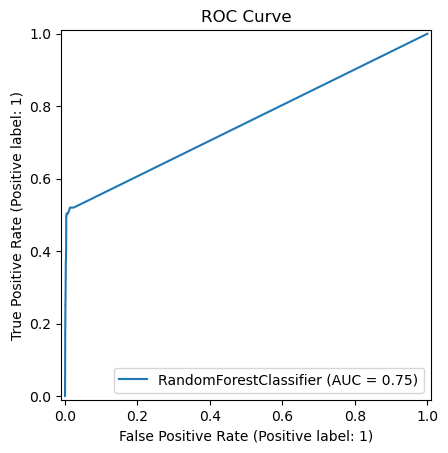

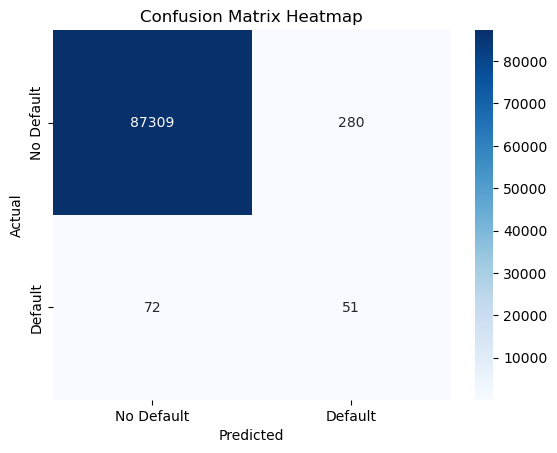

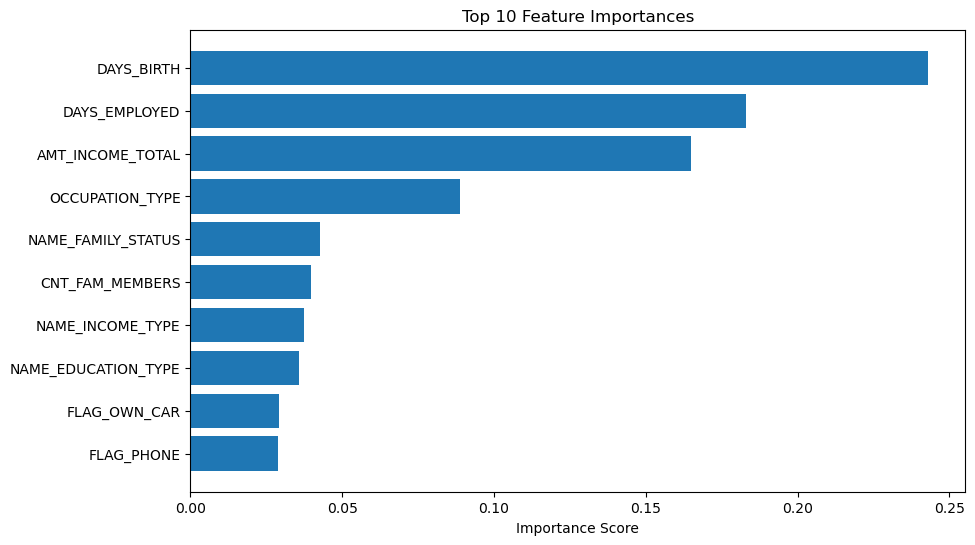

C:\Users\Hemang\AppData\Local\Temp\ipykernel_29572\3813978264.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['DEFAULT'].replace({0: 'No Default', 1: 'Default'}, inplace=True)


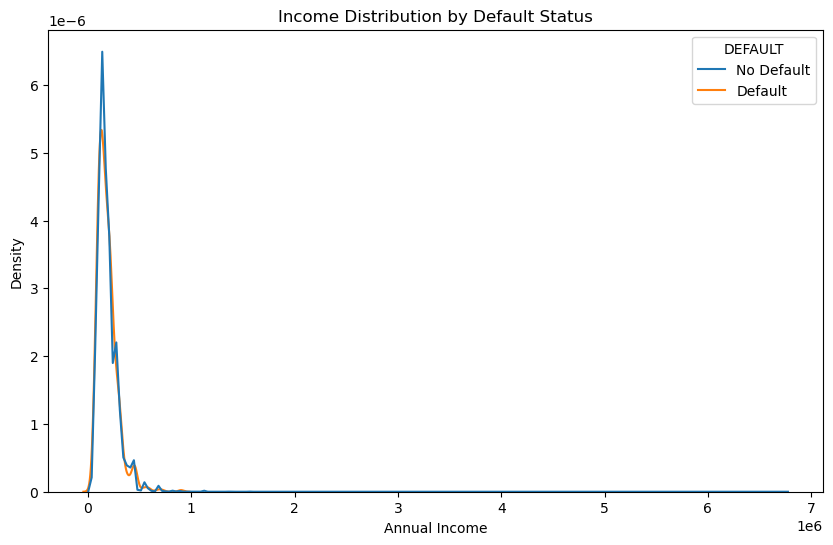

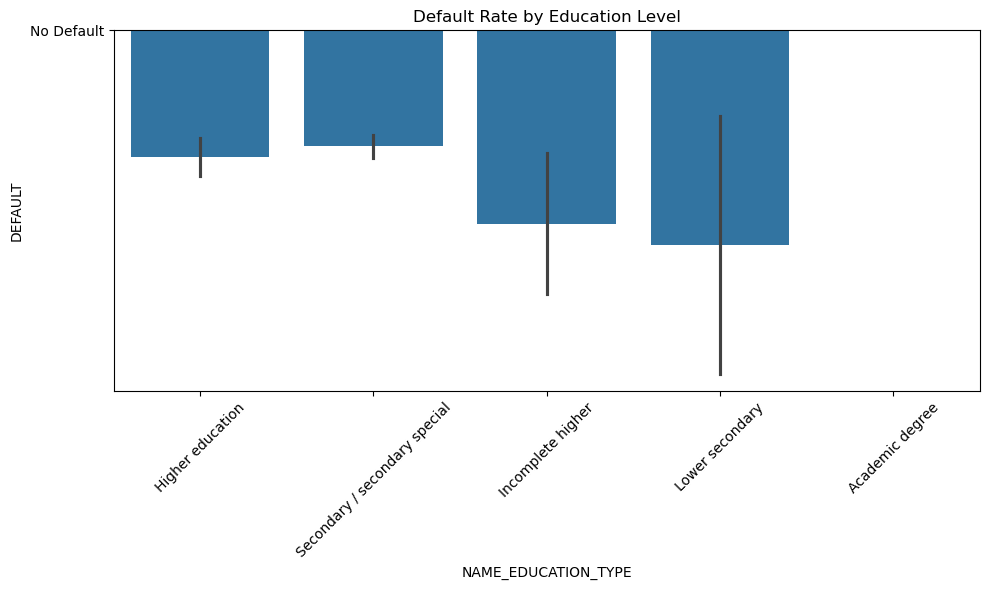

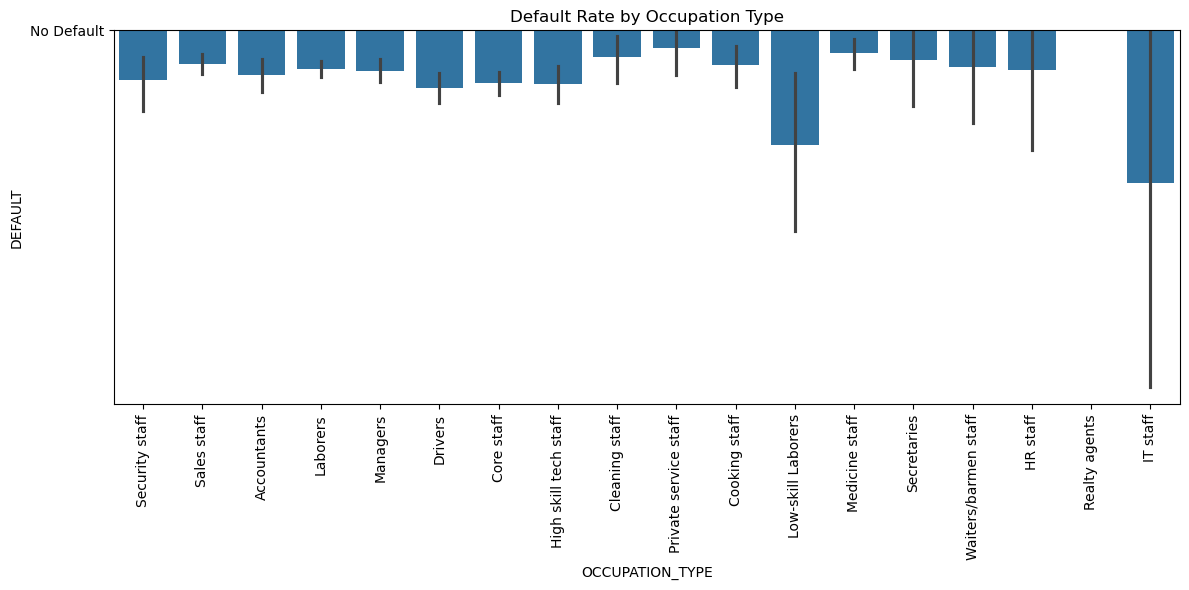

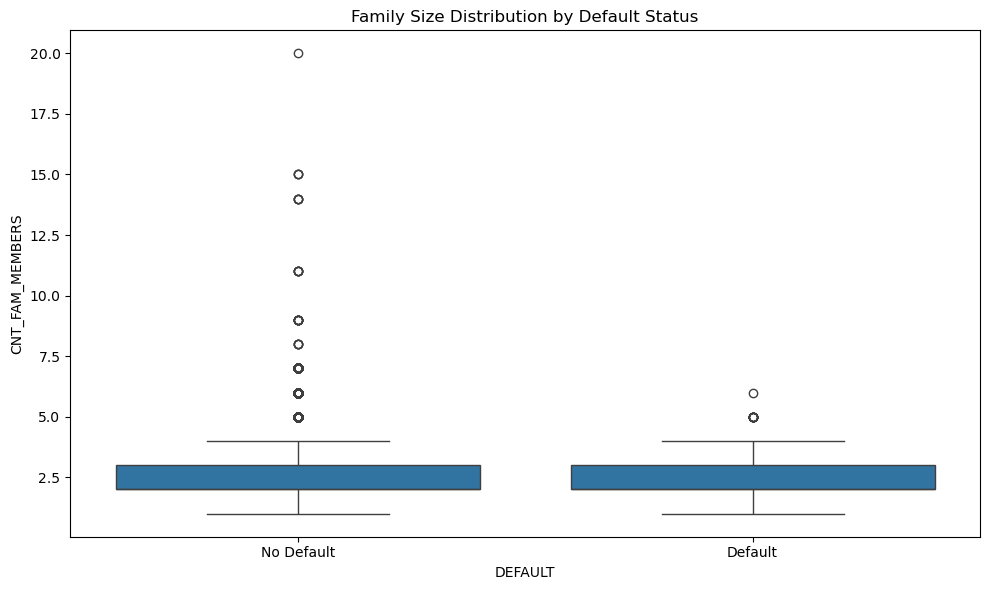

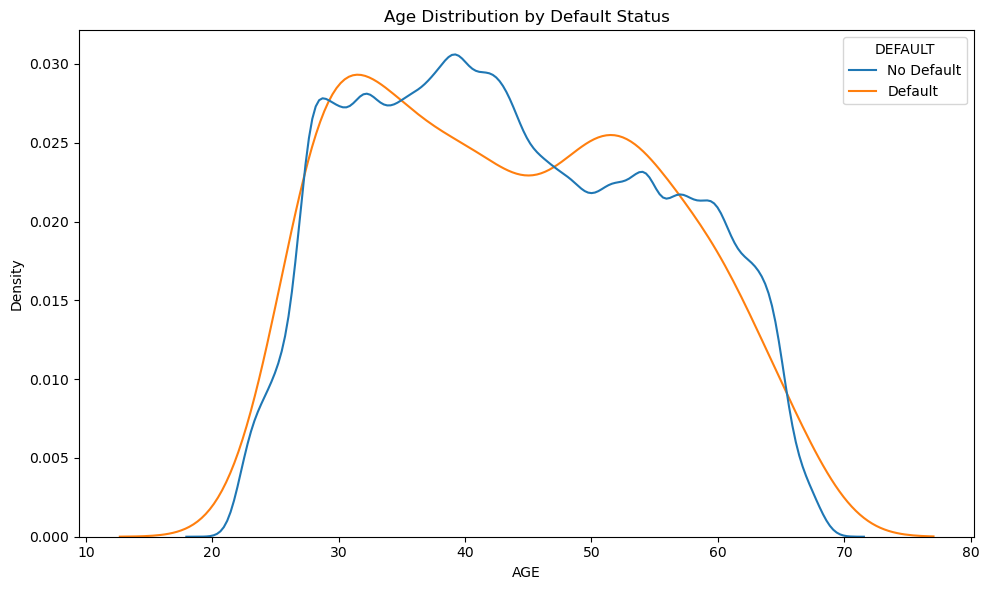

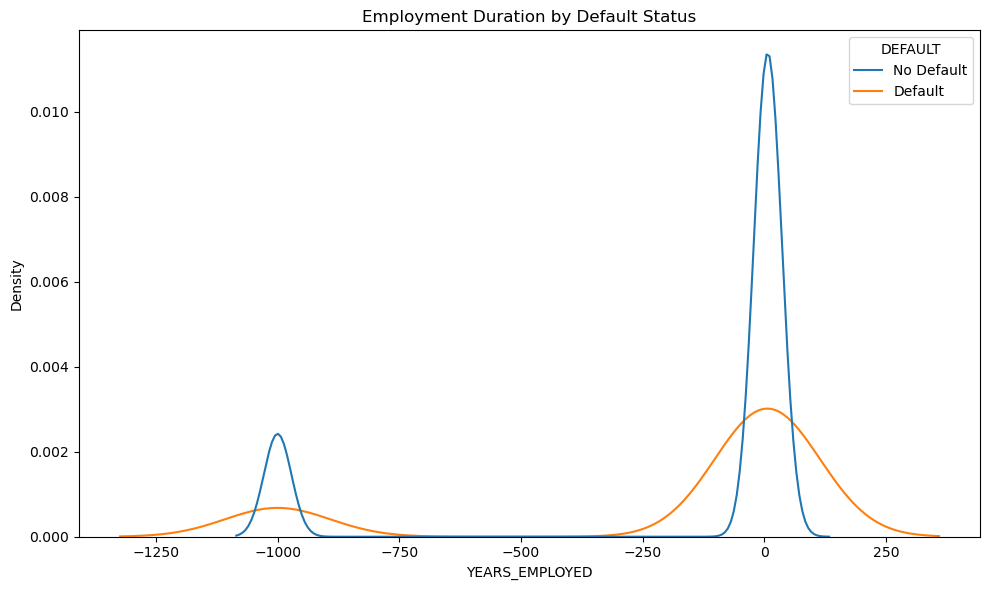

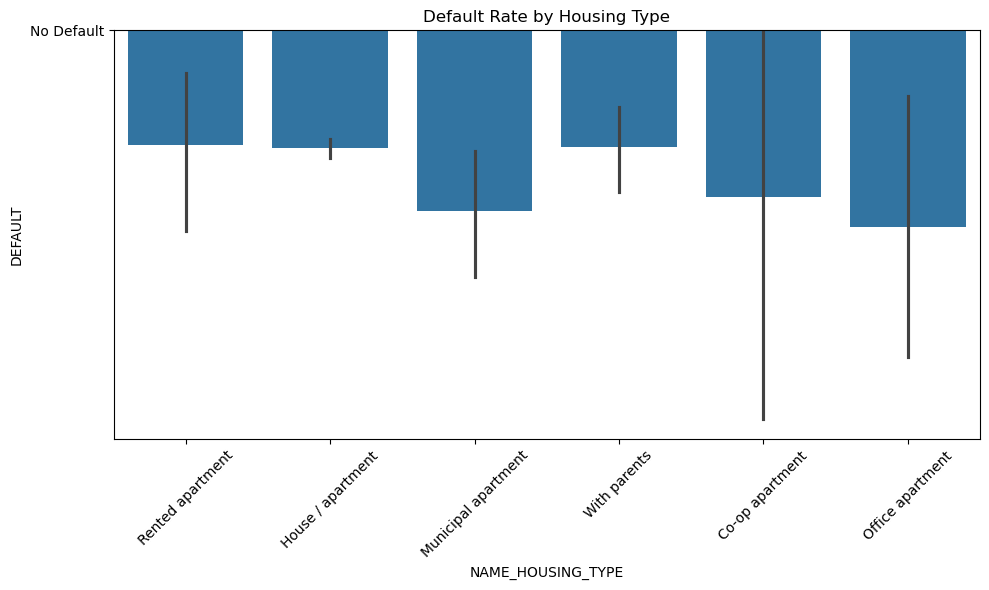

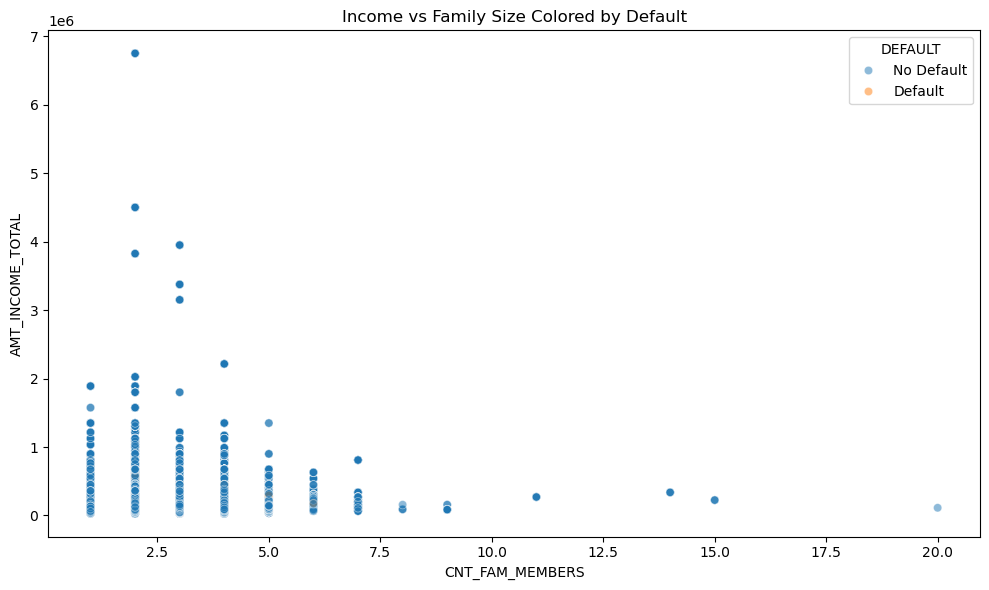

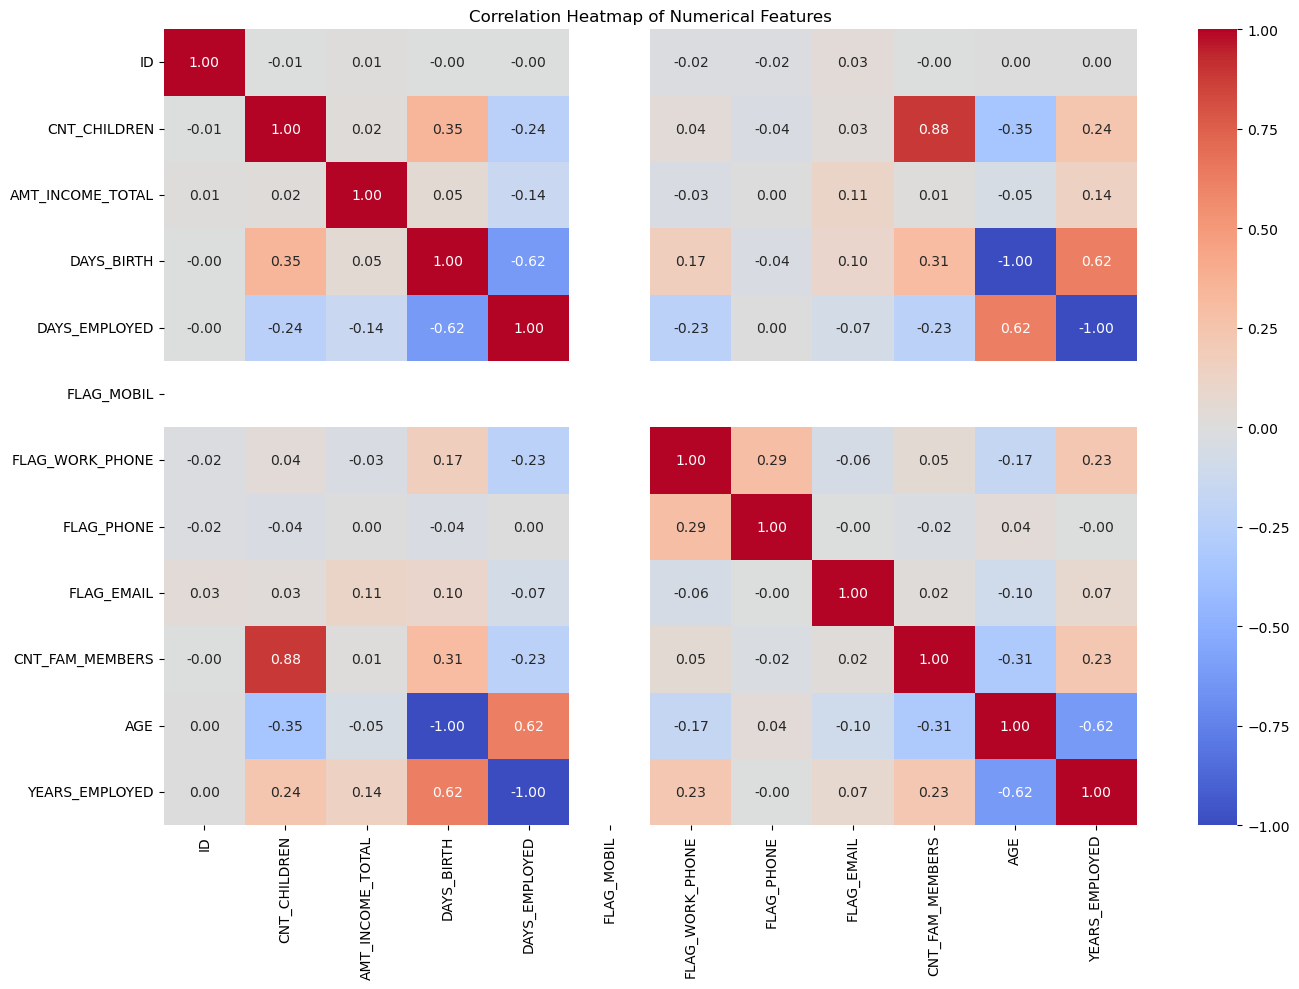

In [21]:
# === Visualizations ===

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

# Confusion Matrix Plot
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importance Score")
plt.show()

# Income distribution by default status
merged_data['DEFAULT'].replace({0: 'No Default', 1: 'Default'}, inplace=True)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_data, x='AMT_INCOME_TOTAL', hue='DEFAULT', common_norm=False)
plt.title("Income Distribution by Default Status")
plt.xlabel("Annual Income")
plt.show()

# 1. Default Rate by Education Level
plt.figure(figsize=(10, 6))
sns.barplot(x='NAME_EDUCATION_TYPE', y='DEFAULT', data=merged_data)
plt.xticks(rotation=45)
plt.title("Default Rate by Education Level")
plt.tight_layout()
plt.show()

# 2. Default Rate by Occupation
plt.figure(figsize=(12, 6))
sns.barplot(x='OCCUPATION_TYPE', y='DEFAULT', data=merged_data)
plt.xticks(rotation=90)
plt.title("Default Rate by Occupation Type")
plt.tight_layout()
plt.show()

# 3. Family Size Distribution by Default
plt.figure(figsize=(10, 6))
sns.boxplot(x='DEFAULT', y='CNT_FAM_MEMBERS', data=merged_data)
plt.title("Family Size Distribution by Default Status")
plt.tight_layout()
plt.show()

# 4. Age Distribution by Default
merged_data['AGE'] = -merged_data['DAYS_BIRTH'] / 365.25
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_data, x='AGE', hue='DEFAULT', common_norm=False)
plt.title("Age Distribution by Default Status")
plt.tight_layout()
plt.show()

# 5. Employment Duration by Default
merged_data['YEARS_EMPLOYED'] = -merged_data['DAYS_EMPLOYED'] / 365.25
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_data, x='YEARS_EMPLOYED', hue='DEFAULT', common_norm=False)
plt.title("Employment Duration by Default Status")
plt.tight_layout()
plt.show()

# 6. Default Rate by Housing Type
plt.figure(figsize=(10, 6))
sns.barplot(x='NAME_HOUSING_TYPE', y='DEFAULT', data=merged_data)
plt.xticks(rotation=45)
plt.title("Default Rate by Housing Type")
plt.tight_layout()
plt.show()

# 7. Income vs Family Size Scatter Plot (Colored by Default)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='CNT_FAM_MEMBERS', y='AMT_INCOME_TOTAL', hue='DEFAULT', alpha=0.5)
plt.title("Income vs Family Size Colored by Default")
plt.tight_layout()
plt.show()

# 8. Correlation Heatmap of Numeric Features
numeric_features = merged_data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_features.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

In [23]:
# === Profit Simulation ===
results = X_test.copy()
results['Actual'] = y_test.values
results['Predicted_Prob_Default'] = y_prob
threshold = 0.3
results['Predicted_Label'] = (y_prob > threshold).astype(int)

def calc_profit(row):
    if row['Predicted_Label'] == 0 and row['Actual'] == 0:
        return 100
    elif row['Predicted_Label'] == 0 and row['Actual'] == 1:
        return -500
    elif row['Predicted_Label'] == 1 and row['Actual'] == 0:
        return -50
    else:
        return 0

results['Simulated_Profit'] = results.apply(calc_profit, axis=1)
print("Total simulated profit:", results['Simulated_Profit'].sum())
print("Average profit per applicant:", results['Simulated_Profit'].mean())

Total simulated profit: 8681300
Average profit per applicant: 98.97505472455309


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import time
import pandas as pd

# Define 4 models (XGBoost removed)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training: {name}")
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC AUC": auc,
        "Train Time (s)": round(end - start, 2)
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="F1 Score", ascending=False))


Training: Logistic Regression
Training: Random Forest
Training: Gradient Boosting
                 Model  Accuracy  F1 Score   ROC AUC  Train Time (s)
1        Random Forest  0.995987  0.224670  0.753467           21.55
2    Gradient Boosting  0.998073  0.175610  0.648299           28.91
0  Logistic Regression  0.603236  0.003436  0.569675            0.83


Training: Logistic Regression
Training: Random Forest
Training: Gradient Boosting
                 Model  Accuracy  F1 Score   ROC AUC  Train Time (s)
1        Random Forest  0.995987  0.224670  0.753467           19.69
2    Gradient Boosting  0.998073  0.175610  0.648299           26.53
0  Logistic Regression  0.603236  0.003436  0.569675            0.79


C:\Users\Hemang\AppData\Local\Temp\ipykernel_29572\3375189045.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=sorted_results, palette="viridis")


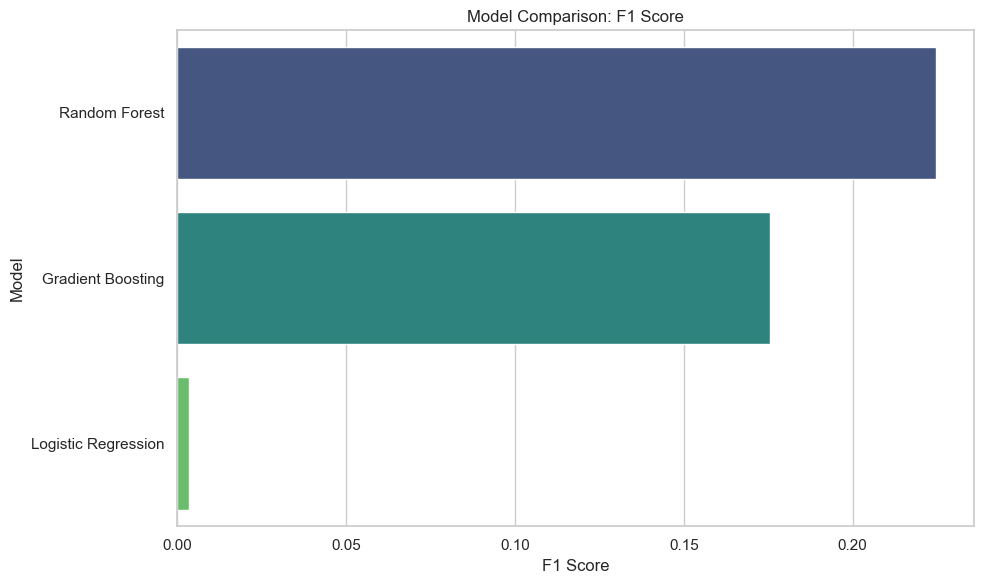

C:\Users\Hemang\AppData\Local\Temp\ipykernel_29572\3375189045.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ROC AUC", y="Model", data=sorted_results, palette="crest")


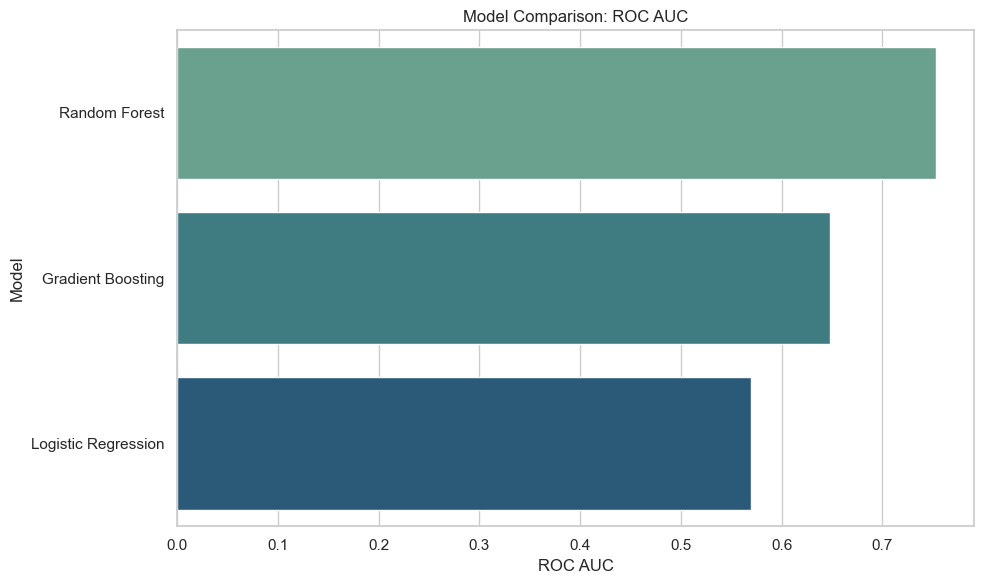

C:\Users\Hemang\AppData\Local\Temp\ipykernel_29572\3375189045.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Train Time (s)", y="Model", data=sorted_results, palette="rocket")


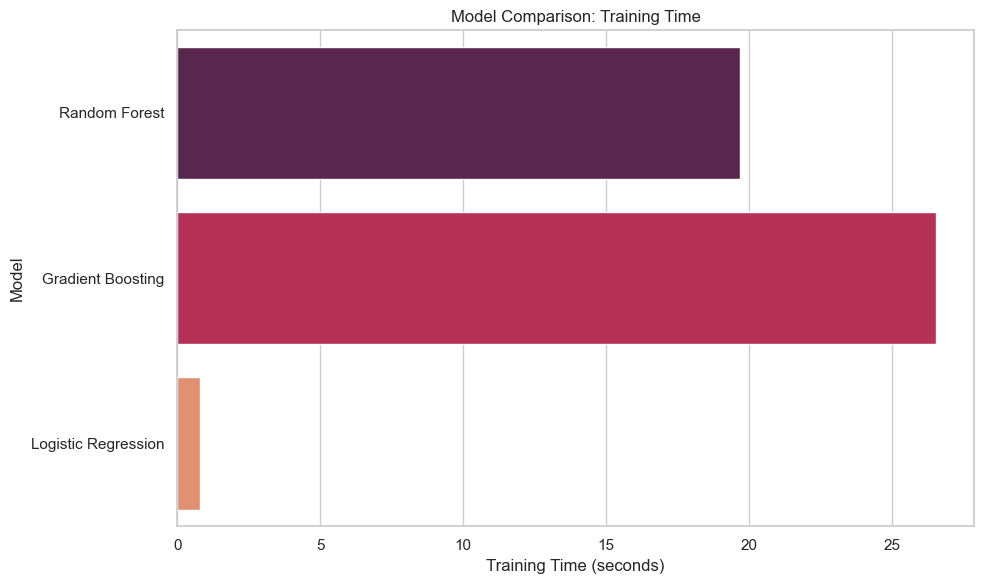

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define 3 models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training: {name}")
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC AUC": auc,
        "Train Time (s)": round(end - start, 2)
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="F1 Score", ascending=False))

# === Model Comparison Graphs ===
sorted_results = results_df.sort_values(by="F1 Score", ascending=False)
sns.set(style="whitegrid")

# F1 Score
plt.figure(figsize=(10, 6))
sns.barplot(x="F1 Score", y="Model", data=sorted_results, palette="viridis")
plt.title("Model Comparison: F1 Score")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# ROC AUC
plt.figure(figsize=(10, 6))
sns.barplot(x="ROC AUC", y="Model", data=sorted_results, palette="crest")
plt.title("Model Comparison: ROC AUC")
plt.xlabel("ROC AUC")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# Training Time
plt.figure(figsize=(10, 6))
sns.barplot(x="Train Time (s)", y="Model", data=sorted_results, palette="rocket")
plt.title("Model Comparison: Training Time")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()
